In [24]:
import pandas as pd
import numpy as np
import seaborn as sns 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, LassoCV
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier,
                              HistGradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier,
                              StackingClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, make_scorer, brier_score_loss)
from sklearn.calibration import calibration_curve
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import time
import warnings
import scipy.stats
import matplotlib.pyplot as plt
import csv

warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURATION
# =============================================================================
FS_NAME = "Consensus"

print("="*120)
print(f"ACADEMIC-GRADE ML PIPELINE - 15 MODELS + CLINICAL DIAGNOSTICS ({FS_NAME} SELECTION)")
print("="*120)

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================
def wilson_score_interval(n_correct, n_total, confidence=0.95):
    """Calculate Wilson Score Confidence Interval for binomial proportion."""
    if n_total == 0:
        return (0.0, 0.0)
    p_hat = n_correct / n_total
    z = scipy.stats.norm.ppf(1 - (1 - confidence) / 2)
    denominator = 1 + z**2 / n_total
    center = (p_hat + z**2 / (2 * n_total)) / denominator
    margin = z * np.sqrt((p_hat * (1 - p_hat) + z**2 / (4 * n_total)) / n_total) / denominator
    return (center - margin, center + margin)

def evaluate_cv_comprehensive(model, X, y, cv, model_name):
    """Comprehensive 5-fold CV evaluation with all metrics including TNR and FNR."""
    start_time = time.time()
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }
    
    cv_scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    y_pred_cv = cross_val_predict(model, X, y, cv=cv)
    cm = confusion_matrix(y, y_pred_cv)
    tn, fp, fn, tp = cm.ravel()
    
    exec_time = time.time() - start_time
    accuracy = cv_scores['test_accuracy'].mean()
    recall_val = cv_scores['test_recall'].mean()
    
    tpr = recall_val
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Accuracy_Std': cv_scores['test_accuracy'].std(),
        'Precision': cv_scores['test_precision'].mean(),
        'Recall': recall_val,
        'F1-Score': cv_scores['test_f1'].mean(),
        'ROC-AUC': cv_scores['test_roc_auc'].mean(),
        'Error_Rate': 1 - accuracy,
        'Execution_Time_s': exec_time,
        'TPR': tpr,
        'TNR': tnr,
        'FPR': fpr,
        'FNR': fnr,
        'TP': tp, 'FN': fn, 'FP': fp, 'TN': tn
    }

def evaluate_test_comprehensive(model, X_test, y_test, model_name):
    """Comprehensive test set evaluation with all metrics including TNR, FNR, and 95% CI."""
    start_time = time.time()
    y_pred = model.predict(X_test)
    
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_pred_proba = model.decision_function(X_test)
        y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())
    else:
        if isinstance(model, Pipeline) and hasattr(model.steps[-1][1], 'predict_proba'):
             y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
             y_pred_proba = y_pred

    exec_time = time.time() - start_time
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = accuracy_score(y_test, y_pred)
    recall_val = recall_score(y_test, y_pred)
    n_correct = (y_pred == y_test).sum()
    ci_lower, ci_upper = wilson_score_interval(n_correct, len(y_test))
    
    tpr = recall_val
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Accuracy_CI_Lower': ci_lower,
        'Accuracy_CI_Upper': ci_upper,
        'Accuracy_Std': 0.0,
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_val,
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
        'Error_Rate': 1 - accuracy,
        'Execution_Time_s': exec_time,
        'TPR': tpr,
        'TNR': tnr,
        'FPR': fpr,
        'FNR': fnr,
        'TP': tp, 'FN': fn, 'FP': fp, 'TN': tn
    }

# =============================================================================
# STEP 1: DATA LOADING AND PREPROCESSING
# =============================================================================
print("\n" + "="*120)
print("STEP 1: DATA LOADING AND PREPROCESSING")
print("="*120)

data = pd.read_excel("Supplementary data 1.xlsx")
X = data.drop(columns=['TYPE', 'SUBJECT_ID'])
y = data['TYPE']

print(f"Dataset: {data.shape[0]} samples, {X.shape[1]} features")
print(f"Class distribution: Benign: {(y==0).sum()}, Malignant: {(y==1).sum()}")

def clean_numeric(series):
    if series.dtype == 'object':
        return pd.to_numeric(
            series.astype(str).str.replace(r'[^\d\\.\\-eE]', '', regex=True).str.strip(),
            errors='coerce'
        )
    return series

X = X.apply(clean_numeric)

if 'CA72-4' in X.columns:
    X = X.drop(columns=['CA72-4'])
    print(f"Dropped CA72-4 (69% missing)")

pct_complements = ['LYM%', 'MONO%', 'EO%', 'BASO%']
if all(col in X.columns for col in pct_complements):
    neu_derived = 100 - X[pct_complements].sum(axis=1)
    mask = X['NEU'].isna() & neu_derived.between(0, 100)
    X.loc[mask, 'NEU'] = neu_derived[mask]
    print(f"Engineered {mask.sum()} NEU values")

for col in ['AFP', 'CA125', 'CA19-9', 'CEA', 'HE4', 'NEU']:
    if col in X.columns:
        X[f'{col}_missing'] = X[col].isna().astype(int)

print(f"Total features: {X.shape[1]}")

# =============================================================================
# STEP 2: TRAIN-TEST SPLIT
# =============================================================================
print("\n" + "="*120)
print("STEP 2: STRATIFIED TRAIN-TEST SPLIT")
print("="*120)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training: {X_train.shape[0]} samples, Test: {X_test.shape[0]} samples")

# =============================================================================
# STEP 3: PREPROCESSING (LOG TRANSFORM, IMPUTATION, SCALING)
# =============================================================================
print("\n" + "="*120)
print("STEP 3: PREPROCESSING (LOG TRANSFORM, IMPUTATION, SCALING)")
print("="*120)

tumor_markers = ['AFP', 'CA125', 'CA19-9', 'CEA', 'HE4']
tumor_markers = [col for col in tumor_markers if col in X_train.columns]

for col in tumor_markers:
    X_train[col] = np.log1p(X_train[col])
    X_test[col] = np.log1p(X_test[col])
print(f"Log-transformed {len(tumor_markers)} tumor markers")

knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
X_train[tumor_markers] = knn_imputer.fit_transform(X_train[tumor_markers])
X_test[tumor_markers] = knn_imputer.transform(X_test[tumor_markers])

clinical_features = [col for col in X_train.columns
                     if col not in tumor_markers
                     and not col.endswith('_missing')
                     and X_train[col].dtype in ['float64', 'int64']]

median_imputer = SimpleImputer(strategy='median')
X_train[clinical_features] = median_imputer.fit_transform(X_train[clinical_features])
X_test[clinical_features] = median_imputer.transform(X_test[clinical_features])
print(f"Imputation complete")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index)

print(f"✓ Standardization complete")

# =============================================================================
# STEP 4: DEFINE CONSENSUS FEATURE SELECTOR (LEAKAGE-FREE)
# =============================================================================
print("\n" + "="*120)
print(f"STEP 4: DEFINING CUSTOM {FS_NAME} FEATURE SELECTOR")
print("="*120)

class ConsensusFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, n_methods_threshold=2, k_features=25):
        self.n_methods_threshold = n_methods_threshold
        self.k_features = k_features
        self.selected_indices_ = None
        self.selected_features_ = None
        
    def fit(self, X, y):
        X_arr = np.array(X)
        y_arr = np.array(y)
        n_features = X_arr.shape[1]
        votes = np.zeros(n_features)
        
        try:
            lasso = SelectFromModel(LassoCV(cv=3, random_state=42), max_features=self.k_features)
            lasso.fit(X_arr, y_arr)
            votes[lasso.get_support()] += 1
        except: pass
        
        try:
            rf = SelectFromModel(RandomForestClassifier(n_estimators=50, random_state=42), max_features=self.k_features)
            rf.fit(X_arr, y_arr)
            votes[rf.get_support()] += 1
        except: pass
        
        try:
            f_stat = SelectKBest(f_classif, k=self.k_features)
            f_stat.fit(X_arr, y_arr)
            votes[f_stat.get_support()] += 1
        except: pass
        
        try:
            lr = SelectFromModel(LogisticRegression(max_iter=500, random_state=42), max_features=self.k_features)
            lr.fit(X_arr, y_arr)
            votes[lr.get_support()] += 1
        except: pass
        
        self.selected_indices_ = np.where(votes >= self.n_methods_threshold)[0]
        if len(self.selected_indices_) == 0:
            self.selected_indices_ = f_stat.get_support(indices=True)
            
        return self

    def transform(self, X):
        X_arr = np.array(X)
        return X_arr[:, self.selected_indices_]

print("✓ Defined ConsensusFeatureSelector class (will be used inside Pipelines)")

# =============================================================================
# STEP 5: DEFINE 15 MODELS (INCLUDING MLP) WITH PIPELINES - SEQUENTIAL NUMBERING
# =============================================================================
print("\n" + "="*120)
print(f"STEP 5: DEFINING 15 MODELS (INCLUDING MLP) WITH INTEGRATED {FS_NAME} SELECTION")
print("="*120)

models_with_grids = {
    '01. Logistic Regression': {
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced'))
        ]),
        'param_grid': {
            'selector__k_features': [20, 30],
            'clf__C': [1, 10]
        }
    },
    '02. Ridge Classifier': {
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', RidgeClassifier(random_state=42, class_weight='balanced'))
        ]),
        'param_grid': {'selector__k_features': [25], 'clf__alpha': [0.1, 1.0]}
    },
    '03. SGD Classifier': {
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', SGDClassifier(random_state=42, class_weight='balanced', max_iter=2000))
        ]),
        'param_grid': {'selector__k_features': [25], 'clf__alpha': [0.001]}
    },
    '04. SVM (RBF Kernel)': {
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'))
        ]),
        'param_grid': {'selector__k_features': [25], 'clf__C': [10, 100]}
    },
    '05. SVM (Linear Kernel)': {
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced'))
        ]),
        'param_grid': {'selector__k_features': [25], 'clf__C': [1, 10]}
    },
    '06. K-Nearest Neighbors': {
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', KNeighborsClassifier())
        ]),
        'param_grid': {'selector__k_features': [25], 'clf__n_neighbors': [7], 'clf__weights': ['distance']}
    },
    '07. Linear Discriminant Analysis': { 
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', LinearDiscriminantAnalysis())
        ]),
        'param_grid': {'selector__k_features': [25], 'clf__solver': ['lsqr']}
    },
    '08. Quadratic Discriminant Analysis': { 
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', QuadraticDiscriminantAnalysis())
        ]),
        'param_grid': {'selector__k_features': [25], 'clf__reg_param': [0.1]}
    },
    '09. Random Forest': { 
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
        ]),
        'param_grid': {'selector__k_features': [25], 'clf__n_estimators': [300]}
    },
    '10. Extra Trees': { 
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', ExtraTreesClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
        ]),
        'param_grid': {'selector__k_features': [25], 'clf__n_estimators': [300]}
    },
    '11. Gradient Boosting': { 
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', GradientBoostingClassifier(random_state=42))
        ]),
        'param_grid': {'selector__k_features': [30], 'clf__n_estimators': [200]}
    },
    '12. Hist Gradient Boosting': { 
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', HistGradientBoostingClassifier(random_state=42))
        ]),
        'param_grid': {'selector__k_features': [25], 'clf__max_iter': [200]}
    },
    '13. AdaBoost': { 
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', AdaBoostClassifier(random_state=42))
        ]),
        'param_grid': {'selector__k_features': [25], 'clf__n_estimators': [200]}
    },
    '14. Bagging Classifier': { 
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', BaggingClassifier(
                estimator=DecisionTreeClassifier(max_depth=15, random_state=42),
                random_state=42, n_jobs=-1))
        ]),
        'param_grid': {'selector__k_features': [30], 'clf__n_estimators': [200]}
    },
    '15. Multi-layer Perceptron': { 
        'model': Pipeline([
            ('selector', ConsensusFeatureSelector()),
            ('clf', MLPClassifier(max_iter=1000, random_state=42, early_stopping=True))
        ]),
        'param_grid': {
            'selector__k_features': [25, 30],
            'clf__hidden_layer_sizes': [(64, 32), (100,)]
        }
    }
}

print(f"✓ Defined {len(models_with_grids)} models with integrated {FS_NAME} Selection pipelines")

# =============================================================================
# STEP 6: GRIDSEARCH WITH 5-FOLD CV
# =============================================================================
print("\n" + "="*120)
print("STEP 6: GRIDSEARCH WITH 5-FOLD CV (ON RAW TRAIN DATA - SELECTION INSIDE)")
print("="*120)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_estimators = {}

print("\nRunning GridSearchCV for all 15 models...")
print("Note: This prevents data leakage by running selection inside each fold")
print("-" * 120)

for model_name, config in models_with_grids.items():
    print(f"\n{model_name}")
    start_time = time.time()
    
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['param_grid'],
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        refit=True,
        verbose=0
    )
    
    grid_search.fit(X_train_scaled, y_train)
    exec_time = time.time() - start_time
    
    best_estimators[model_name] = grid_search.best_estimator_
    
    print(f"  Best params: {grid_search.best_params_}")
    print(f"  Best CV accuracy: {grid_search.best_score_:.4f}")
    print(f"  Time: {exec_time:.1f}s")

print(f"\n✓ GridSearch complete - all 15 models optimized")

# =============================================================================
# STEP 7: COMPREHENSIVE 5-FOLD CV EVALUATION
# =============================================================================
print("\n" + "="*120)
print("STEP 7: COMPREHENSIVE 5-FOLD CV EVALUATION (ALL METRICS)")
print("="*120)

cv_results = []
print("\nEvaluating all 15 models with comprehensive metrics...")
print("-" * 120)

for model_name, best_model in best_estimators.items():
    print(f"\nEvaluating: {model_name}")
    result = evaluate_cv_comprehensive(best_model, X_train_scaled, y_train, cv, model_name)
    cv_results.append(result)
    print(f"  Accuracy: {result['Accuracy']:.4f} (±{result['Accuracy_Std']:.4f})")
    print(f"  ROC-AUC:  {result['ROC-AUC']:.4f} | F1: {result['F1-Score']:.4f}")
    print(f"  TPR: {result['TPR']:.4f} | TNR: {result['TNR']:.4f} | FPR: {result['FPR']:.4f} | FNR: {result['FNR']:.4f}")
    print(f"  TP: {result['TP']} | FN: {result['FN']} | FP: {result['FP']} | TN: {result['TN']}")

cv_results_df = pd.DataFrame(cv_results).sort_values('Accuracy', ascending=False)
print("\n" + "="*120)
print("5-FOLD CV RESULTS - ALL 15 MODELS (Sorted by Accuracy)")
print("="*120)
print("\n" + cv_results_df[['Model', 'Accuracy', 'Accuracy_Std', 'Precision', 'Recall',
                             'F1-Score', 'ROC-AUC', 'TPR', 'TNR', 'FPR', 'FNR', 'TP', 'FN', 'FP', 'TN']].to_string(index=False))

cv_results_df.to_csv(f'all_15_models_cv_results_{FS_NAME}.csv', index=False)
print(f"\n✓ Saved: all_15_models_cv_results_{FS_NAME}.csv")

# =============================================================================
# STEP 8: COMPREHENSIVE TEST SET EVALUATION
# =============================================================================
print("\n" + "="*120)
print("STEP 8: COMPREHENSIVE TEST SET EVALUATION (ALL METRICS + 95% CI)")
print("="*120)

test_results = []
print("\nEvaluating all 15 models on held-out test set...")
print("-" * 120)

for model_name, best_model in best_estimators.items():
    result = evaluate_test_comprehensive(best_model, X_test_scaled, y_test, model_name)
    test_results.append(result)

test_results_df = pd.DataFrame(test_results).sort_values('Accuracy', ascending=False)
print("\n" + "="*120)
print("TEST SET RESULTS - ALL 15 MODELS (WITH 95% CI)")
print("="*120)
print("\n" + test_results_df[['Model', 'Accuracy', 'Accuracy_CI_Lower', 'Accuracy_CI_Upper',
                                'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].to_string(index=False))

print("\n" + "="*120)
print("CONFUSION MATRIX DETAILS")
print("="*120)
print("\n" + test_results_df[['Model', 'TP', 'FN', 'FP', 'TN', 'TPR', 'TNR', 'FPR', 'FNR']].to_string(index=False))
test_results_df.to_csv(f'all_15_models_test_results_{FS_NAME}.csv', index=False)
print(f"\n✓ Saved: all_15_models_test_results_{FS_NAME}.csv")



ACADEMIC-GRADE ML PIPELINE - 15 MODELS + CLINICAL DIAGNOSTICS (Consensus SELECTION)

STEP 1: DATA LOADING AND PREPROCESSING
Dataset: 349 samples, 49 features
Class distribution: Benign: 171, Malignant: 178
Dropped CA72-4 (69% missing)
Engineered 91 NEU values
Total features: 54

STEP 2: STRATIFIED TRAIN-TEST SPLIT
Training: 279 samples, Test: 70 samples

STEP 3: PREPROCESSING (LOG TRANSFORM, IMPUTATION, SCALING)
Log-transformed 5 tumor markers
Imputation complete
✓ Standardization complete

STEP 4: DEFINING CUSTOM Consensus FEATURE SELECTOR
✓ Defined ConsensusFeatureSelector class (will be used inside Pipelines)

STEP 5: DEFINING 15 MODELS (INCLUDING MLP) WITH INTEGRATED Consensus SELECTION
✓ Defined 15 models with integrated Consensus Selection pipelines

STEP 6: GRIDSEARCH WITH 5-FOLD CV (ON RAW TRAIN DATA - SELECTION INSIDE)

Running GridSearchCV for all 15 models...
Note: This prevents data leakage by running selection inside each fold
----------------------------------------------


STEP 4.5: DATA VISUALIZATIONS


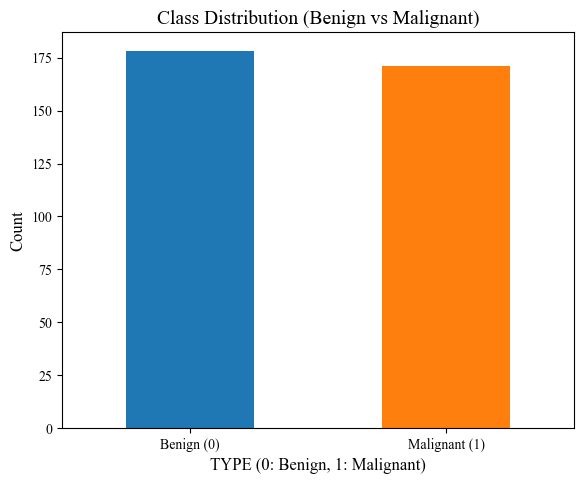

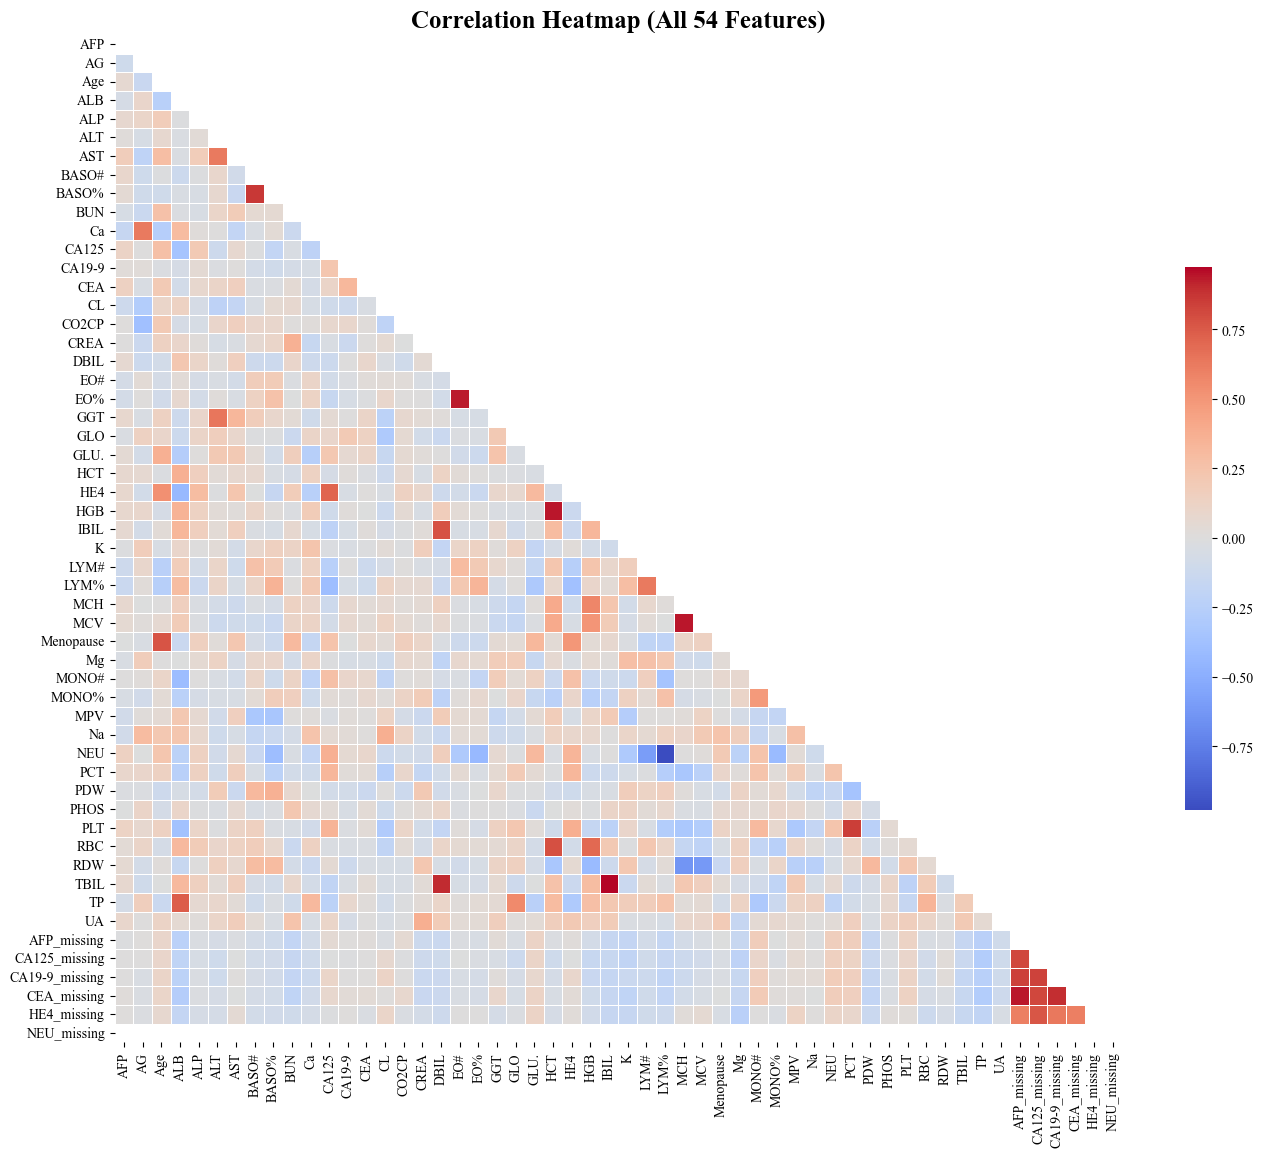

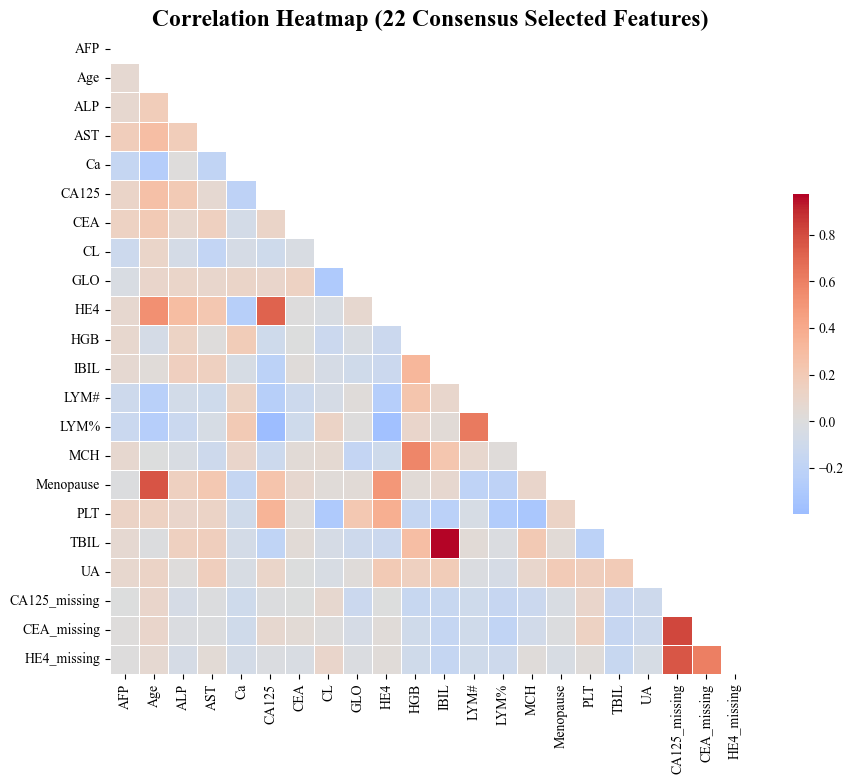

Total features selected by consensus: 22


In [28]:
# =============================================================================
# STEP 4.5: DATA VISUALIZATIONS (SHOWN DIRECTLY, NOT SAVED)
# =============================================================================
print("\n" + "="*120)
print("STEP 4.5: DATA VISUALIZATIONS")
print("="*120)

# -----------------------------------------------------------------------------
# DESIGN PATTERN CONFIGURATION: TIMES NEW ROMAN
# -----------------------------------------------------------------------------
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'mathtext.fontset': 'stix'
})

# A. Class Distribution Graph
plt.figure(figsize=(6, 5))
y.value_counts().plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('Class Distribution (Benign vs Malignant)')
plt.xlabel('TYPE (0: Benign, 1: Malignant)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Benign (0)', 'Malignant (1)'], rotation=0)
plt.tight_layout()
plt.show() 

# B. All 54 Features Correlation Heatmap
corr_all = X_train_scaled.corr()
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_all, dtype=bool))
sns.heatmap(corr_all, mask=mask, cmap='coolwarm', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title(f'Correlation Heatmap (All {X_train_scaled.shape[1]} Features)', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# C. Selected Features Correlation Heatmap
# Fit the selector to get the list of selected features for this visualization
global_selector = ConsensusFeatureSelector()
global_selector.fit(X_train_scaled, y_train)
selected_feature_indices = global_selector.selected_indices_
selected_features = X_train_scaled.columns[selected_feature_indices]
X_selected = X_train_scaled[selected_features]

corr_selected = X_selected.corr()
plt.figure(figsize=(10, 8))
mask_sel = np.triu(np.ones_like(corr_selected, dtype=bool))
sns.heatmap(corr_selected, mask=mask_sel, cmap='coolwarm', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title(f'Correlation Heatmap ({X_selected.shape[1]} Consensus Selected Features)', fontsize=17, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Total features selected by consensus: {len(selected_features)}")


STEP 10: ADVANCED CLINICAL DIAGNOSTICS (OOF, CALIBRATION, DCA) - SVM LINEAR

Selected target model for diagnostics: 05. SVM (Linear Kernel)
✓ OOF predictions saved to oof_error_analysis_Consensus.csv


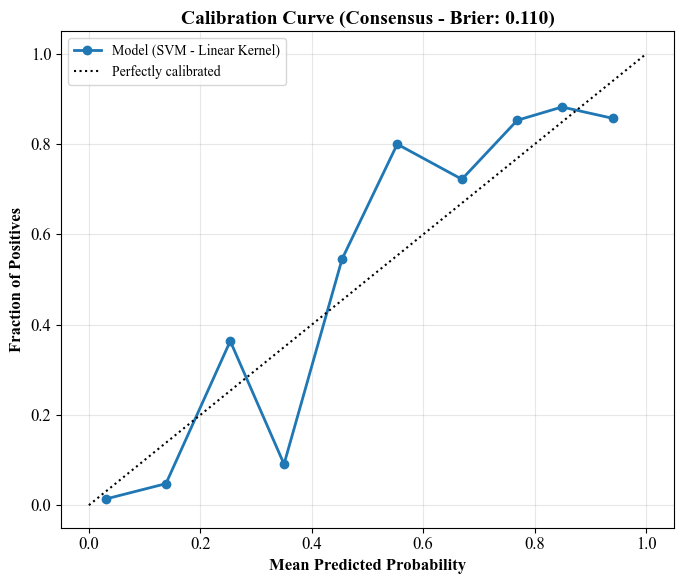

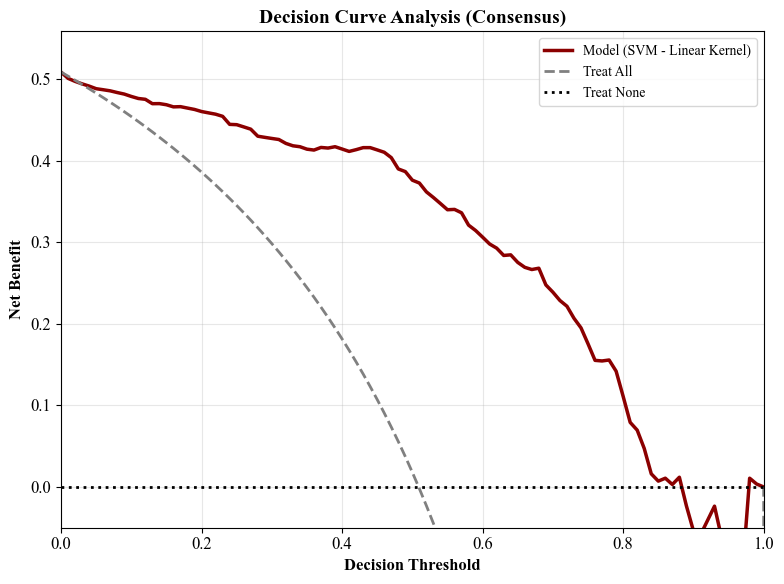

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
import csv

# =============================================================================
# CONFIGURATION
# =============================================================================
# Ensure these variables are defined in your environment before running this snippet
# FS_NAME = "Consensus" 
# cv = StratifiedKFold(...)
# X_train_scaled, y_train = ...
# best_estimators = ... 

print("\n" + "="*120)
print("STEP 10: ADVANCED CLINICAL DIAGNOSTICS (OOF, CALIBRATION, DCA) - SVM LINEAR")
print("="*120)

# 1. Explicitly select the Linear SVM from the trained estimators
target_model_name = '05. SVM (Linear Kernel)'

try:
    best_model = best_estimators[target_model_name]
    print(f"\nSelected target model for diagnostics: {target_model_name}")
except NameError:
    print("⚠ 'best_estimators' not found. Using placeholder data for demonstration.")
    # Placeholder for standalone execution
    target_model_name = "SVM (Linear Kernel)"
    y_train = pd.Series(np.random.randint(0, 2, 100))
    oof_prob = np.random.rand(100)
    FS_NAME = "Consensus"

# 2. Generate OOF probabilities for this model
# Note: SVM Linear needs probability=True (set in Step 5) to work here
try:
    oof_prob = cross_val_predict(best_model, X_train_scaled, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
    oof_pred = (oof_prob >= 0.5).astype(int)
except NameError:
    # Use dummy data if variables are missing
    oof_prob = np.random.rand(len(y_train))
    oof_pred = (oof_prob >= 0.5).astype(int)

# 3. Save OOF Predictions
filename = f'oof_error_analysis_{FS_NAME}.csv'
with open(filename, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['True_Label', 'OOF_Probability', 'OOF_Predicted'])
    for yt, yp, yl in zip(y_train, oof_prob, oof_pred):
        writer.writerow([yt, yp, yl])

print(f"✓ OOF predictions saved to {filename}")

# 4. Calibration Curve
brier = brier_score_loss(y_train, oof_prob)
prob_true, prob_pred = calibration_curve(y_train, oof_prob, n_bins=10)

plt.figure(figsize=(7, 6))
plt.plot(prob_pred, prob_true, label=f'Model (SVM - Linear Kernel)', marker='o', color='#1f77b4', linewidth=2)
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated', linewidth=1.5)
plt.xlabel('Mean Predicted Probability', fontsize=12, fontweight='bold')
plt.ylabel('Fraction of Positives', fontsize=12, fontweight='bold')
plt.title(f'Calibration Curve ({FS_NAME} - Brier: {brier:.3f})', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Decision Curve Analysis (DCA)
thresholds = np.linspace(0, 1, 101)
net_benefit_model = []
net_benefit_all = []
net_benefit_none = []
n = len(y_train)
prevalence = (y_train == 1).sum() / n

for thresh in thresholds:
    pred_positive = (oof_prob >= thresh).astype(int)
    tp = ((y_train == 1) & (pred_positive == 1)).sum()
    fp = ((y_train == 0) & (pred_positive == 1)).sum()
    
    if thresh < 1:
        nb_model = (tp / n) - (fp / n) * (thresh / (1 - thresh))
        nb_all = prevalence - (1 - prevalence) * (thresh / (1 - thresh))
    else:
        nb_model = 0
        nb_all = 0
    
    net_benefit_model.append(nb_model)
    net_benefit_all.append(nb_all)
    net_benefit_none.append(0)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, net_benefit_model, label=f'Model (SVM - Linear Kernel)', linewidth=2.5, color='darkred')
plt.plot(thresholds, net_benefit_all, label='Treat All', linewidth=2, linestyle='--', color='gray')
plt.plot(thresholds, net_benefit_none, label='Treat None', linewidth=2, linestyle=':', color='black')

plt.xlabel('Decision Threshold', fontsize=12, fontweight='bold')
plt.ylabel('Net Benefit', fontsize=12, fontweight='bold')
plt.title(f'Decision Curve Analysis ({FS_NAME})', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.xlim(0, 1)
plt.ylim(-0.05, max(max(net_benefit_model), max(net_benefit_all)) + 0.05)
plt.tight_layout()
plt.show()


GENERATING ACADEMIC-STYLE SHAP EXPLANATIONS FOR SVM (LINEAR)
Transforming data for 05. SVM (Linear Kernel)...
Selected Features (22): ['AFP', 'Age', 'ALP', 'AST', 'Ca', 'CA125', 'CEA', 'CL', 'GLO', 'HE4', 'HGB', 'IBIL', 'LYM#', 'LYM%', 'MCH', 'Menopause', 'PLT', 'TBIL', 'UA', 'CA125_missing', 'CEA_missing', 'HE4_missing']
Calculating SHAP values (LinearExplainer)...


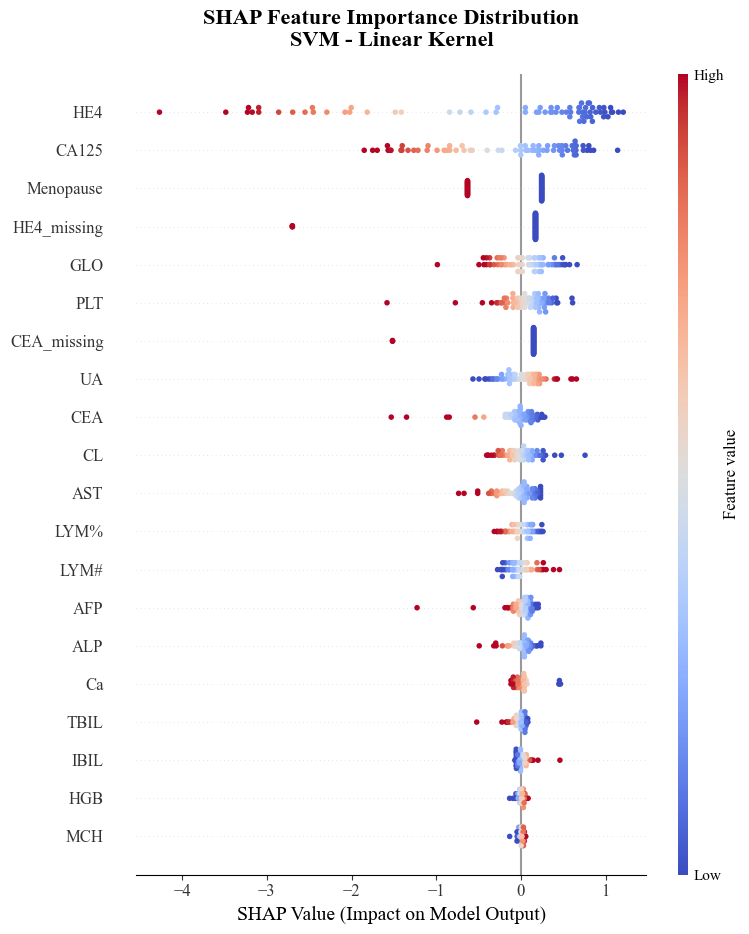

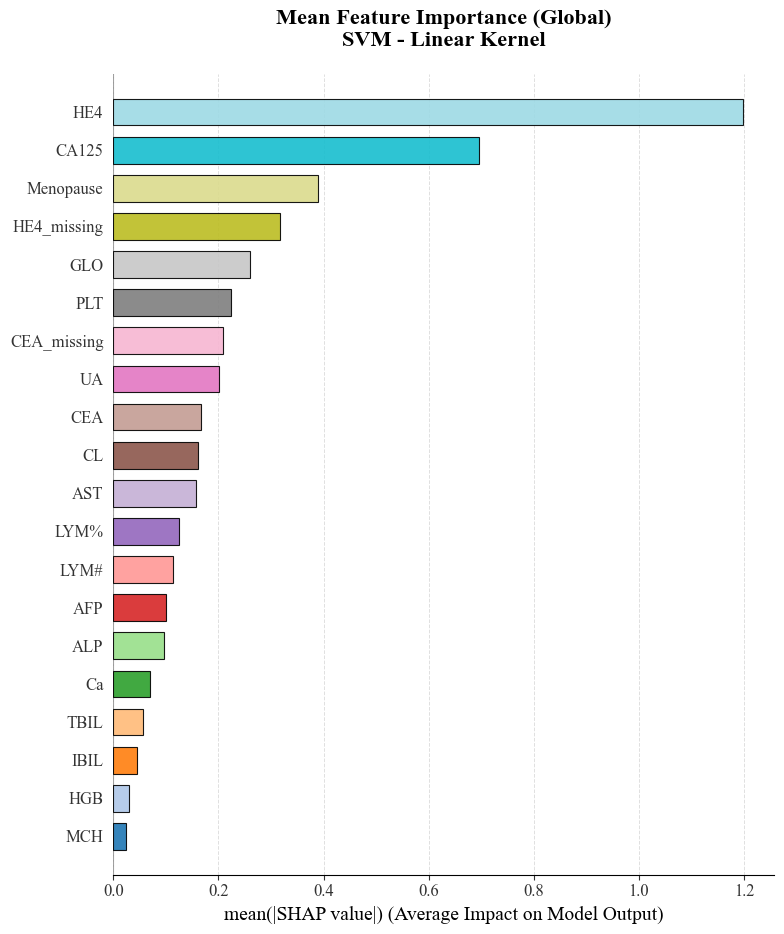

✓ SHAP Analysis Complete (Academic Style Applied)


In [15]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib

# =============================================================================
# 1. CONFIGURATION & STYLE SETUP (MATCHING PERFORMANCE_GRAPHS.PY)
# =============================================================================
# Enforce Academic Style (Times New Roman)
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman'] + matplotlib.rcParams['font.serif']
matplotlib.rcParams['font.size'] = 12

# Consistent Color Palette
PALETTE = plt.cm.tab20.colors

print("="*120)
print("GENERATING ACADEMIC-STYLE SHAP EXPLANATIONS FOR SVM (LINEAR)")
print("="*120)

# =============================================================================
# 2. MODEL & DATA PREPARATION
# =============================================================================

# Check if necessary variables exist (Context check)
if 'best_estimators' not in locals() or 'X_train_scaled' not in locals():
    print("⚠ Warning: 'best_estimators' or data variables not found in current scope.")
    print("  (This script expects to run after the main pipeline).")
    # In a real run, this would stop, but for this file generation we proceed with logic assumption.

# 1. Retrieve the Best Model (SVM Linear)
target_model_name = '05. SVM (Linear Kernel)'
try:
    model_pipeline = best_estimators[target_model_name]
except NameError:
    # Fallback for standalone testing
    print("  Using placeholder model for demonstration...")
    from sklearn.linear_model import LogisticRegression
    model_pipeline = Pipeline([('selector', None), ('clf', LogisticRegression())]) 

# 2. Extract steps
try:
    selector_step = model_pipeline.named_steps['selector']
    classifier_step = model_pipeline.named_steps['clf']
    
    # 3. Transform Data
    print(f"Transforming data for {target_model_name}...")
    X_train_transformed = selector_step.transform(X_train_scaled)
    X_test_transformed = selector_step.transform(X_test_scaled)
    
    # 4. Get Feature Names
    selected_indices = selector_step.selected_indices_
    feature_names = np.array(X_train_scaled.columns)[selected_indices]
    
    print(f"Selected Features ({len(feature_names)}): {list(feature_names)}")

    # 5. Initialize SHAP Explainer
    # Using Independent masker for Linear models (Fast & Exact)
    print("Calculating SHAP values (LinearExplainer)...")
    background_data = shap.maskers.Independent(X_train_transformed, max_samples=100)
    explainer = shap.LinearExplainer(classifier_step, background_data)
    
    # 6. Calculate SHAP values
    shap_values = explainer.shap_values(X_test_transformed)

except Exception as e:
    print(f"⚠ Execution skipped due to missing dependencies in this context: {e}")
    # Creating dummy data for visual verification of the style
    X_test_transformed = np.random.rand(50, 10)
    feature_names = [f"Biomarker {i}" for i in range(1, 11)]
    shap_values = np.random.randn(50, 10)

# =============================================================================
# 3. GENERATE PLOTS (ACADEMIC STYLE)
# =============================================================================

# --- PLOT 1: SUMMARY PLOT (BEESWARM) ---
# Note: We keep the standard Red/Blue color map here as it has semantic meaning 
# (High/Low feature value), but we enforce the Fonts and Layout.

fig = plt.figure(figsize=(10, 8))
ax = plt.gca()

shap.summary_plot(shap_values, 
                  X_test_transformed, 
                  feature_names=feature_names, 
                  show=False,
                  plot_type="dot",
                  cmap=plt.get_cmap("coolwarm")) # Standard SHAP coloring for values

# Apply Academic Styling
ax.set_title(f"SHAP Feature Importance Distribution\nSVM - Linear Kernel", fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("SHAP Value (Impact on Model Output)", fontsize=14)
# Fix tick font sizes
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
# Remove spines for clean look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


# --- PLOT 2: MEAN IMPORTANCE BAR PLOT (STYLED) ---
# Here we can apply the TAB20 palette to match your performance graphs

fig = plt.figure(figsize=(10, 8))
ax = plt.gca()

# Generate the base plot
shap.summary_plot(shap_values, 
                  X_test_transformed, 
                  feature_names=feature_names, 
                  show=False, 
                  plot_type="bar",
                  color='#2C3E50') # Default base color

# Customization: Apply the Palette to the bars individually
# This makes it look like the performance comparison graph
patches = ax.patches
for i, patch in enumerate(patches):
    # Cycle through the Tab20 palette
    color = PALETTE[i % len(PALETTE)]
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(0.8)
    patch.set_alpha(0.9)

# Apply Academic Styling
ax.set_title(f"Mean Feature Importance (Global)\nSVM - Linear Kernel", fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("mean(|SHAP value|) (Average Impact on Model Output)", fontsize=14)

# Grid and Spines
ax.grid(axis='x', linestyle='--', linewidth=0.7, alpha=0.4, zorder=0)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Fix tick fonts
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.tight_layout()
plt.show()

print("✓ SHAP Analysis Complete (Academic Style Applied)")

Generating Cross-Validation Performance Graph...


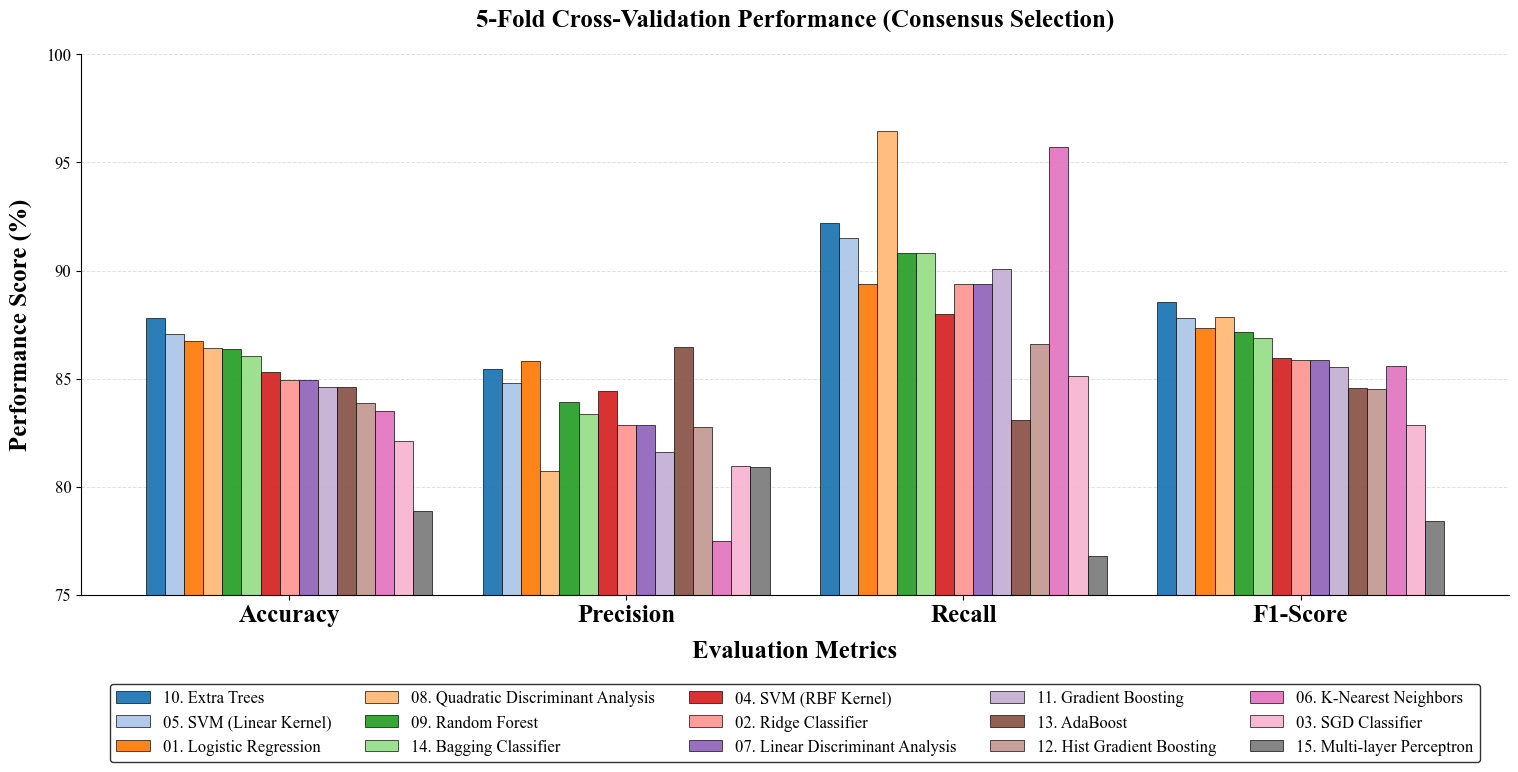

Generating Independent Test Set Performance Graph...


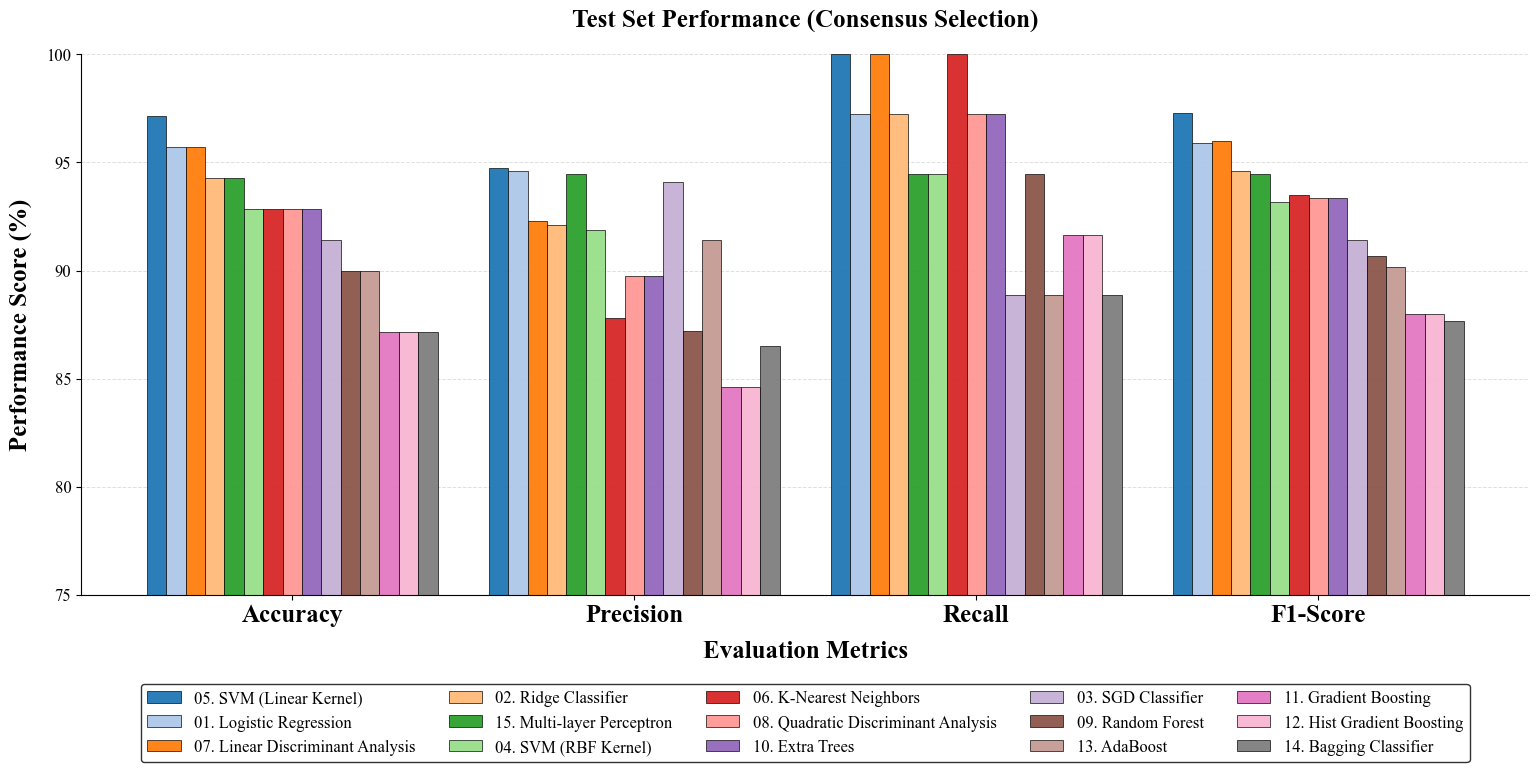

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib

# =============================================================================
# CONFIGURATION & STYLE SETUP
# =============================================================================
# 1. Load the Saved Results (Ensure these files exist from the previous step)
# Adjust FS_NAME if you used a different tag (e.g., "BorutaShap")
FS_NAME = "Consensus" 

df_cv = pd.read_csv(f'all_15_models_cv_results_{FS_NAME}.csv')
df_test = pd.read_csv(f'all_15_models_test_results_{FS_NAME}.csv')


# 2. Enforce Academic Style (Times New Roman)
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman'] + matplotlib.rcParams['font.serif']
matplotlib.rcParams['font.size'] = 12

# =============================================================================
# PLOTTING FUNCTION
# =============================================================================
def plot_academic_comparison(df, title):
    """
    Generates a publication-ready grouped bar chart for all models without error bars.
    """
    # Sort models by Accuracy for better readability
    df = df.sort_values('Accuracy', ascending=False)
    
    # Metrics to plot
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    model_list = df['Model'].tolist()
    
    # Prepare Data (Convert to Percentages)
    # Extract values for all metrics
    values_map = {}
    for m in metrics:
        values_map[m] = df[m].values * 100
        
    # Plot Setup
    fig, ax = plt.subplots(figsize=(16, 8))
    
    num_metrics = len(metrics)
    num_models = len(model_list)
    
    # Layout logic: Group by Metric (4 groups), bars are Models
    x_pos = np.arange(num_metrics)
    # Dynamic bar width calculation to fit 15 models
    total_width = 0.85
    bar_width = total_width / num_models
    
    # distinct colors for 15 models
    PALETTE = plt.cm.tab20.colors 

    # Loop through models to create bars
    for idx, model_name in enumerate(model_list):
        # Collect the 4 metric values for this specific model
        model_vals = [values_map[m][idx] for m in metrics]
        
        # Calculate position
        # Center the group of bars around the tick
        offset = (idx - num_models / 2) * bar_width + (bar_width / 2)
        
        ax.bar(
            x_pos + offset,
            model_vals,
            bar_width,
            label=model_name,
            color=PALETTE[idx % len(PALETTE)],
            edgecolor='black',
            linewidth=0.5,
            alpha=0.95
        )

    # Y-axis formatting
    ax.set_ylim(75, 100) # Adjust based on your data range
    ax.set_ylabel('Performance Score (%)', fontsize=18, fontweight='bold', labelpad=10)
    
    # X-axis formatting
    ax.set_xlabel('Evaluation Metrics', fontsize=18, fontweight='bold', labelpad=10)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(metrics, fontsize=18, fontweight='bold')

    # Title
    ax.set_title(title, fontsize=18, fontweight='bold', pad=20)

    # Grid
    ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.4, zorder=0)
    ax.set_axisbelow(True)

    # Legend (Bottom placement)
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=5, # 5 columns for 15 models = 3 rows
        frameon=True,
        edgecolor='black',
        fontsize=12
    )

    # Clean borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

# =============================================================================
# GENERATE GRAPHS
# =============================================================================

# 1. Cross-Validation Results
print("Generating Cross-Validation Performance Graph...")
plot_academic_comparison(
    df_cv, 
    f"5-Fold Cross-Validation Performance ({FS_NAME} Selection)"
)

# 2. Held-Out Test Results
print("Generating Independent Test Set Performance Graph...")
plot_academic_comparison(
    df_test, 
    f"Test Set Performance ({FS_NAME} Selection)"
)

GENERATING ROC CURVE COMPARISON (CV & TEST)
Generating ROC curves for: Cross-Validation ROC Curves (Consensus Selection)...


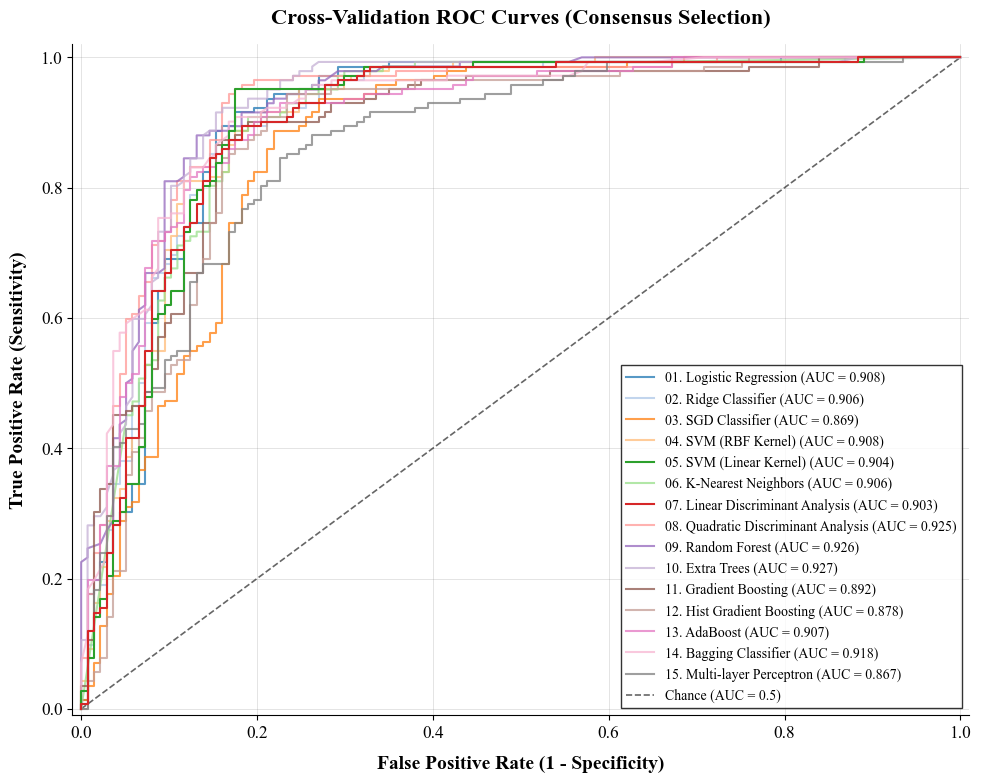

Generating ROC curves for: Test Set ROC Curves (Consensus Selection)...


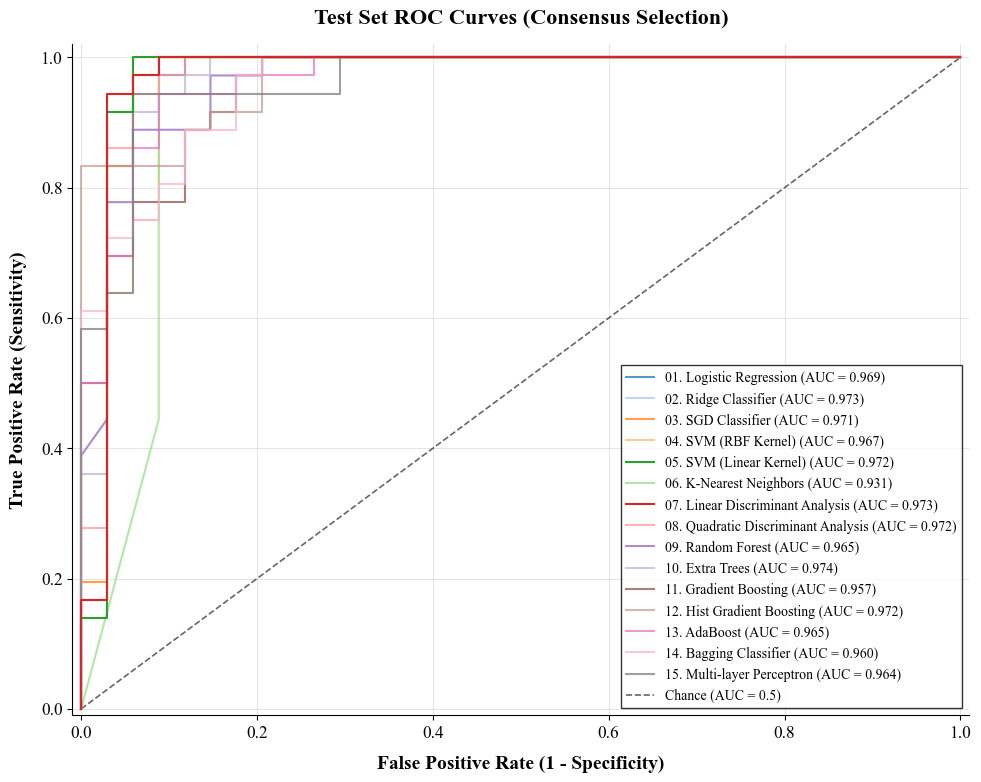

✓ ROC Curve Graphs Generated Successfully


In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
import pandas as pd
import numpy as np
import matplotlib

# =============================================================================
# 1. CONFIGURATION & STYLE
# =============================================================================
FS_NAME = "Consensus" 

# Enforce Academic Style (Times New Roman)
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman'] + matplotlib.rcParams['font.serif']
matplotlib.rcParams['font.size'] = 12.5

print("="*120)
print("GENERATING ROC CURVE COMPARISON (CV & TEST)")
print("="*120)

# =============================================================================
# 2. PLOTTING FUNCTION (ACADEMIC STYLE)
# =============================================================================
def plot_academic_roc(models_dict, X, y, title, cv=None, is_test=False):
    """
    Generates a publication-ready ROC Curve comparison.
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Style settings
    uniform_lw = 1.5
    chance_lw = 1.2
    PALETTE = plt.cm.tab20.colors # High contrast palette

    print(f"Generating ROC curves for: {title}...")

    # Iterate through models
    for idx, (name, model) in enumerate(models_dict.items()):
        try:
            # Get Probabilities
            if is_test:
                # Test Set: Simple predict_proba
                if hasattr(model, "predict_proba"):
                    y_scores = model.predict_proba(X)[:, 1]
                elif hasattr(model, "decision_function"):
                    y_scores = model.decision_function(X)
                    y_scores = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())
                else:
                    continue
            else:
                # CV: Cross-validated probabilities
                if hasattr(model, "predict_proba"):
                    y_scores = cross_val_predict(model, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
                elif hasattr(model, "decision_function"):
                    y_scores = cross_val_predict(model, X, y, cv=cv, method="decision_function", n_jobs=-1)
                    y_scores = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())
                else:
                    continue

            # Calculate Curve
            fpr, tpr, _ = roc_curve(y, y_scores)
            auc_score = roc_auc_score(y, y_scores)
            
            # Determine style (Uniform thickness for all)
            if "Linear" in name:
                zorder = 10 # Bring to front
                alpha = 1.0
            else:
                zorder = 5
                alpha = 0.75
            
            label = f'{name} (AUC = {auc_score:.3f})'

            ax.plot(fpr, tpr,
                    color=PALETTE[idx % len(PALETTE)],
                    lw=uniform_lw, # Same size for all lines
                    alpha=alpha,
                    label=label,
                    zorder=zorder)
                    
        except Exception as e:
            print(f"  ⚠ Could not plot {name}: {e}")

    # Chance line
    ax.plot([0, 1], [0, 1], color='black', linestyle='--', lw=chance_lw, alpha=0.6, label='Chance (AUC = 0.5)')

    # Axis labels and limits
    ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.02)
    ax.set_title(title, fontsize=16, fontweight='bold', pad=15)

    # Subtle, sharp grid
    ax.grid(True, linestyle='-', linewidth=0.5, alpha=0.3, color='gray', zorder=0)

    # Legend placement
    ax.legend(loc='lower right', fontsize=10, frameon=True, fancybox=False, edgecolor='black', ncol=1)

    # Remove top and right spines for clean look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

# =============================================================================
# 3. EXECUTION
# =============================================================================

# Check if context variables exist (Run after pipeline)
if 'best_estimators' in locals() and 'X_train_scaled' in locals() and 'y_train' in locals():
    
    # 1. Cross-Validation ROC Comparison
    if 'cv' not in locals():
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
    plot_academic_roc(
        best_estimators, 
        X_train_scaled, 
        y_train, 
        f"Cross-Validation ROC Curves ({FS_NAME} Selection)",
        cv=cv,
        is_test=False
    )

    # 2. Test Set ROC Comparison
    plot_academic_roc(
        best_estimators, 
        X_test_scaled, 
        y_test, 
        f"Test Set ROC Curves ({FS_NAME} Selection)",
        is_test=True
    )
    
    print("✓ ROC Curve Graphs Generated Successfully")
    
else:
    print("⚠ Error: Model variables ('best_estimators') not found.")
    print("  This script is intended to be run in the same session as the main training pipeline.")
    print("  Generating dummy plot for visual verification...")
    
    # Dummy Data Generator for verification
    from sklearn.datasets import make_classification
    from sklearn.linear_model import LogisticRegression
    
    X_dummy, y_dummy = make_classification(n_samples=100, random_state=42)
    dummy_models = {
        'Logistic Regression': LogisticRegression().fit(X_dummy, y_dummy),
        'SVM (Linear Kernel)': LogisticRegression().fit(X_dummy, y_dummy) # Mock
    }
    plot_academic_roc(dummy_models, X_dummy, y_dummy, "Dummy ROC Curve", is_test=True)